In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as random
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, Flatten
import os
import h5py
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy.stats.mstats import gmean

In [2]:
# Generates a randomized timeshift, outputs that timeshift and the corresponding angle
def timeshift_gen(D):
    """
    D - distance between elements
    """
    #Random angle that the signal is approaching at (-60 to 60)
    #Most phased arrays go -60 to 60 degrees
    angle = np.random.uniform(-1,1)*60
    c = 3e8 # Speed of light
    
    #Calculate the time difference between the two antenna elements
    angle_rad = np.radians(angle)
    timeshift = (np.sin(angle_rad)*D)/c
    
    return timeshift, angle


In [3]:
#Apply the timeshift to the signal
def apply_shift(signal, timeshift, fc, fs):
    # delta(t0) -> exp(-2j*omega*t0)
    # delta(t1) -> exp(-2j*omega*t1)
    # nyquist_component = sum signal[n] * exp(-2j*pi*1/2*n)
    #                   = sum signal[n] * exp(-j*pi*n)
    #                   = sum signal[n] * -1^n
    # nyquist_component of delta(t0) = exp(-j*pi*t0/ts)/2 + exp(j*pi*t0/ts)/2
    #                                = cos(pi*t0/ts)

    # Make sure the signal is an even amount of samples
    n = len(signal)
    assert n%2 == 0 
    
    # Perform an FFT on the signal
    signal_1_f = np.fft.fft(signal)
    signal_1_f = np.fft.fftshift(signal_1_f)
    
    # Get the value from the first index
    signal_1_f_0 = signal_1_f[0]
    
    # Create a frequency array using the sampling frequency and center frequency
    freqs = np.array(range(-n//2, n//2))/n * fs
    freqs = freqs + fc
    
    # Apply the timeshift
    signal_1_f = signal_1_f*np.exp(-1j*2*np.pi*freqs*timeshift)
    signal_1_f[0] = signal_1_f_0 * np.cos(2*np.pi*fs/2*timeshift) * np.exp(-1j*2*np.pi*fc*timeshift)
    
    # Convert from FFT to time signal
    signal_1_f = np.fft.fftshift(signal_1_f)
    signal_1_t = np.fft.ifft(signal_1_f)
    
    return signal_1_t

In [4]:
# This function takes the signals data/labels, and seperates them into seperate NN inputs
# It will output the different datasets and lables.

def corr_data(signal_0, signal_1, angles, starts, stops, center, bandwidth):
    
    # Create arrays to store the labels, and datasets 
    n = len(signal_0[0])
    dataset2 = []
    labels2 = []
    dataset = []
    dataset3 = []
    labels3 = []
    labels = []
    temp_real = []
    temp_imag = []
    temp_corr = []

    # Perform the correllation for use in the AoA prediction
    for i in range(len(signal_0)):
        temp = signal.correlate(signal_0[i], signal_1[i], mode ='same', method = 'auto')
        temp_corr.append(temp) 
    
    # Split correlation information into it's real component and normalize
    temp_real = np.real(temp_corr)
    temp_real = temp_real/100
    
    # Split the correlation information into it's imaginary component and normalize
    temp_imag = np.imag(temp_corr)
    temp_imag = temp_imag/(2*np.pi)
    
    # Convert the angle labels to radians and normalize
    angles = np.radians(angles)
    angles_scaled = angles/(np.pi/2)
    
    # Perform the FFT of the signal for use in the frequency portion of the network
    signal_0_f = np.fft.fft(signal_0); #signal_0_f = np.fft.fftshift(signal_0_f)
    
    for i in range(len(temp_real)):
        # Append the correlated signal parts (real and imaginary) into a single array
        sigs = [temp_real[i], temp_imag[i]]
        
        # Append the angle labels into an array
        params = angles_scaled[i]
        
        # Append the start/stop time labels into a sinle array
        params2 = [starts[i]/len(signal_0[0]), stops[i]/len(signal_0[0])]
        
        # Append the frequency (center freq / bandwidth) labels into a single array
        params3 = [center[i], bandwidth[i]]
        
        # Append the labels and datasets into a singular new array
        dataset.append(sigs)
        dataset2.append(signal_0[i])
        dataset3.append(np.abs(signal_0_f[i]))
        labels.append(params)
        labels2.append(params2)
        labels3.append(params3)
        
    return dataset, dataset2, dataset3, labels, labels2, labels3
    

In [5]:
#This function takes the two signals and applies noise
def add_noise(signal, noise):
    # Generate randomized real and imaginary noise
    real_noise_0 = np.random.normal(0,noise, len(signal))
    imag_noise_0 = 1j*np.random.normal(0,noise, len(signal))
    
    # Add the noise to the signal
    signal_noise = signal + real_noise_0 + imag_noise_0

    return signal_noise

In [6]:
# Tests to see if there is a GPU available
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


In [7]:
# Read in the files for training (/data/signal_discover_cnn/2048_Angles_First.h5) is the file available on the binder
with h5py.File("/data/signal_discovery_cnn/2048_Angles_First.h5", "r") as f:
    # List all groups
    items = f.keys()               #Checks what "folders" are within the file
    G1 = f.get('generated_data')   #Gets the contents of the generated data folder
    
    # Collect the signals and store them into an array
    signal_0 = np.array(G1.get('signal_0'));
    #signal_1 = np.array(G1.get('signal_1'));
    
    # Collect the labels and store them into arrays
    starts = np.array(G1.get('starts'));
    stops = np.array(G1.get('stops'));
    center = np.array(G1.get('centers'))
    bandwidth = np.array(G1.get('bandwidths'))
    #angles = np.array(G1.get('angles'));
    print(len(signal_0))
    
    

30000


In [8]:
# Define an array for time shifted signals
signal_1 = []

# Define an array for the angle
angles = []

D = 0.05 # Distance between elements
fc = 2e9 # Center Frequency
fs = 5e6 # Sampling frequency

for i in range(len(signal_0)):
    timeshift, temp_angle = timeshift_gen(D) # Get the angle and time delay
    signal_1_t = apply_shift(signal_0[i], timeshift, fc, fs)  # Apply the timeshift
    signal_1.append(signal_1_t) # Append the signal to a list
    angles.append(temp_angle) # Append the angle to a list

# Conver to numpy arrays
signal_1 = np.array(signal_1)
angles = np.array(angles)

In [9]:
# Add noise to each of the signals
# Varying noise levels for each of the signals
for i in range(len(signal_0)):
    noise = np.random.uniform(0,0.2) # Generate a random noise value
    
    # Add noise to each of the signals
    signal_0[i] = add_noise(signal_0[i], noise)
    signal_1[i] = add_noise(signal_1[i], noise)

In [10]:
# Pass the signals and the labels into the data prep function
# This will perform pre processing on the signals (FFT, Correlation) and some normalization. Then it will output the data and labels into seperate lists
angleX, timeX, freqX, angleY, timeY, freqY = corr_data(signal_0, signal_1, angles, starts, stops, center, bandwidth)

In [11]:
#Convert the datasets to numpy arrays
angleX = np.array(angleX)
timeX = np.array(timeX)
angleY = np.array(angleY)
timeY = np.array(timeY)
freqX = np.array(freqX)
freqY = np.array(freqY)

In [12]:
# Shuffle the data

# Create new lists for the shuffled data
train_angleX = []; test_angleX = []
train_timeX = [];  test_timeX = []
train_angleY = []; test_angleY = []
train_timeY = []; test_timeY = []
train_freqX = []; test_freqX = []
train_freqY = []; test_freqY = []

# Generate shuffled indexes
N = len(angleX)
indexes = list(range(N))
np.random.shuffle(indexes)

M = int(N* 0.2) # 80/20 train/test split

# Split the validation portion of the data
for idx in indexes[0:M]:
    test_angleX.append(angleX[idx])
    test_timeX.append(timeX[idx])
    test_angleY.append(angleY[idx])
    test_timeY.append(timeY[idx])
    test_freqX.append(freqX[idx])
    test_freqY.append(freqY[idx])

# Split the training portion of the data
for idx in indexes[M:]:
    train_timeX.append(timeX[idx])
    train_angleX.append(angleX[idx])
    train_angleY.append(angleY[idx])
    train_timeY.append(timeY[idx])
    train_freqX.append(freqX[idx])
    train_freqY.append(freqY[idx])

# Convert to np arrays
train_angleX = np.array(train_angleX)
train_timeX = np.array(train_timeX)
train_angleY = np.array(train_angleY)
train_timeY = np.array(train_timeY)
train_freqX = np.array(train_freqX)
train_freqY = np.array(train_freqY)

test_angleX = np.array(test_angleX)
test_timeX = np.array(test_timeX)
test_angleY = np.array(test_angleY)
test_timeY = np.array(test_timeY)
test_freqX = np.array(test_freqX)
test_freqY = np.array(test_freqY)

In [13]:
# Delete old variables to clear memory up.
del angleX
del timeX
del angleY
del timeY
del freqX
del freqY

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Time_Input (InputLayer)         [(None, 2048, 1)]    0                                            
__________________________________________________________________________________________________
Frequency_Input (InputLayer)    [(None, 2048, 1)]    0                                            
__________________________________________________________________________________________________
Time_Conv1 (Conv1D)             (None, 2046, 16)     64          Time_Input[0][0]                 
__________________________________________________________________________________________________
Freq_Conv1 (Conv1D)             (None, 2046, 16)     64          Frequency_Input[0][0]            
____________________________________________________________________________________________

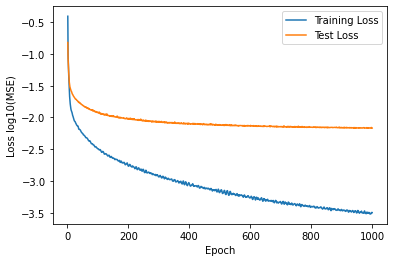

In [16]:
###############
# AoA Portion
###############
# Input of the AoA portion of the network
input1 = Input(shape=(2,2048), name="Angle_Input")    #Input format is [real, imag] of correllated elements

layer1 = Dense(4096, activation='tanh', name="Angle_Dense1")(input1)

layer2 = Dense(2048, activation='tanh', name="Angle_Dense2")(layer1)

layer3 = Dense(1024, activation='tanh', name = "Angle_Dense3")(layer2)

# Pass through flatten then output layer
angle_output = Flatten(name = "Angle_Flatten")(layer3)
angle_output = Dense(1, activation = 'tanh', name='Angle_Out')(angle_output)



###############
# Time Portion
###############
#Input for the time portion of the network
input2 = Input(shape=(2048,1), name="Time_Input")

# Pass through conv layers
layer11 = Conv1D(filters=32/2, kernel_size = 3,activation="relu", name="Time_Conv1")(input2)
layer11 = MaxPooling1D(2, name="Time_Pool1")(layer11)

layer12 = Conv1D(filters=64/2, kernel_size = 3,activation="relu", name="Time_Conv2")(layer11)
layer12 = MaxPooling1D(2, name="Time_Pool2")(layer12)

layer13 = Conv1D(filters = 64/2, kernel_size = 3,activation="relu", name="Time_Conv3")(layer12)
layer13 = MaxPooling1D(2, name="Time_Pool3")(layer13)

layer14 = Conv1D(filters = 128/2, kernel_size = 3,activation="relu", name="Time_Conv4")(layer13)
layer14 = MaxPooling1D(2, name="Time_Pool4")(layer14)

layer15 = Conv1D(filters=256/2, kernel_size = 3,activation="relu" , name="Time_Conv5")(layer14)
layer15 = MaxPooling1D(3, name="Time_Pool5")(layer15)

# Pass through flatten then output layer
time_output = Flatten(name="Time_Flatten")(layer15)
time_output = Dense(2, activation='relu', name='Time_Out')(time_output)

###############
# Freq Portion
###############
# Input for the frequency portion of the network 
input3 = Input(shape=(2048,1), name="Frequency_Input")    #Test input_time, input_angle

# Pass through conv layers
layer21 = Conv1D(filters=32/2, kernel_size = 3,activation="tanh", name = "Freq_Conv1")(input3)
layer21 = MaxPooling1D(2, name = "Freq_Pool1")(layer21)

layer22 = Conv1D(filters=64/2, kernel_size = 3,activation="tanh", name = "Freq_Conv2")(layer21)
layer22 = MaxPooling1D(2, name = "Freq_Pool2")(layer22)

layer23 = Conv1D(filters = 64/2, kernel_size = 3,activation="tanh", name = "Freq_Conv3")(layer22)
layer23 = MaxPooling1D(2, name = "Freq_Pool3")(layer23)

layer24 = Conv1D(filters = 128/2, kernel_size = 3,activation="tanh", name = "Freq_Conv4")(layer23)
layer24 = MaxPooling1D(2, name = "Freq_Pool4")(layer24)

layer25 = Conv1D(filters=256/2, kernel_size = 3,activation="tanh", name = "Freq_Conv5")(layer24)
layer25 = MaxPooling1D(3, name = "Freq_Pool5")(layer25)

# Pass through flatten then output layer
output_freq = Flatten(name="Freq_Flatten")(layer25)
output_freq = Dense(2, activation="tanh", name='Frequency_Out')(output_freq)

# set the input and output layers
model = Model(inputs=[input1, input2, input3], outputs=[angle_output, time_output, output_freq])
model.summary() # print layer info

# Set the optimizer and learning rate
opt = keras.optimizers.Adam(learning_rate = 0.00001)

# Compile model
model.compile(optimizer = opt,
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])
      
# Train the model (verbose = 2 prints the statistics only after each epoch, helped with the memory issues I was having in the binder)
history = model.fit([train_angleX, train_timeX, train_freqX], [train_angleY, train_timeY, train_freqY], epochs=1000, batch_size=100,
          validation_data=([test_angleX, test_timeX, test_freqX], [test_angleY, test_timeY, test_freqY]), verbose = 2)

# Get the losses to plot
training_loss = np.log10(history.history['loss'])
test_loss = np.log10(history.history ['val_loss'])

# Set the epoch count
epoch_count = range(1, len(training_loss) + 1)

# Plot the loss values
plt.plot(epoch_count, training_loss)
plt.plot(epoch_count, test_loss)
plt.legend(["Training Loss","Test Loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss log10(MSE)')
plt.show()


Angle -- NN Output:  -41.22667908668518 Actual Label:  -41.72770088683242
Start -- CNN Output:  274.6422119140625 Actual Label:  277.0
Stop -- CNN Output:  1160.122802734375 Actual Label:  1184.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


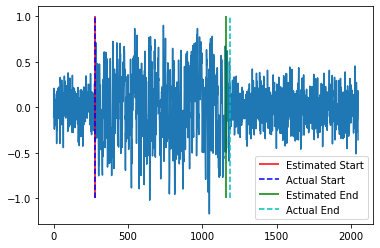

Center Frequency -- CNN Output:  0.0029708308 Actual Label:  0.0139624
Bandwidth -- CNN Output:  0.22035055 Actual Label:  0.2506806


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


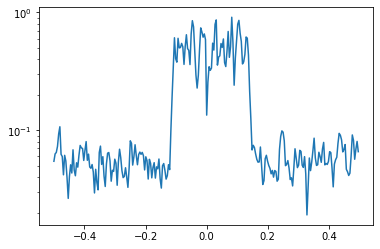


Angle -- NN Output:  -43.30591410398483 Actual Label:  -46.33811101965348
Start -- CNN Output:  242.65611267089844 Actual Label:  233.0
Stop -- CNN Output:  1229.831787109375 Actual Label:  1220.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


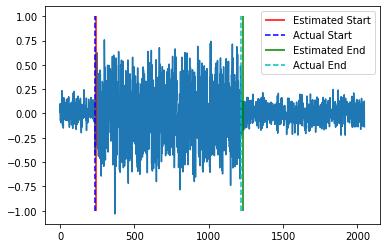

Center Frequency -- CNN Output:  -0.007044404 Actual Label:  -0.0064032
Bandwidth -- CNN Output:  0.8391682 Actual Label:  0.8357382


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


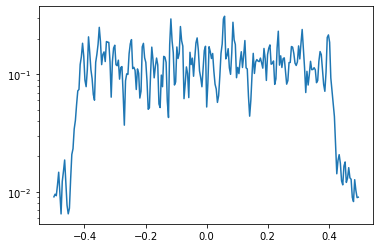


Angle -- NN Output:  26.273610591888428 Actual Label:  17.58385852080529
Start -- CNN Output:  1113.739990234375 Actual Label:  1129.0
Stop -- CNN Output:  1945.67431640625 Actual Label:  1954.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


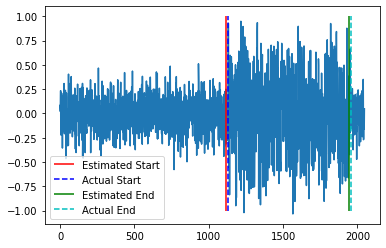

Center Frequency -- CNN Output:  0.03344658 Actual Label:  0.0312782
Bandwidth -- CNN Output:  0.65155756 Actual Label:  0.6397546


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


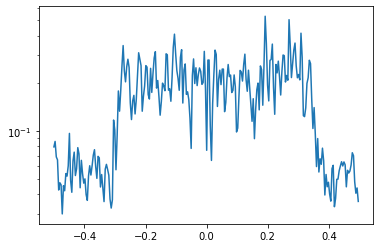


Angle -- NN Output:  -42.780506908893585 Actual Label:  -54.67678471592416
Start -- CNN Output:  1193.9554443359375 Actual Label:  1205.0
Stop -- CNN Output:  1703.292724609375 Actual Label:  1711.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


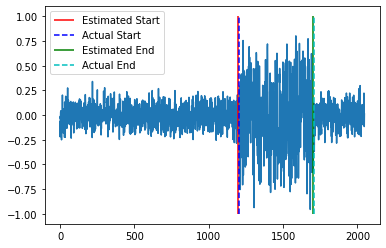

Center Frequency -- CNN Output:  0.012946122 Actual Label:  -0.0006294
Bandwidth -- CNN Output:  0.5032553 Actual Label:  0.5009078


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


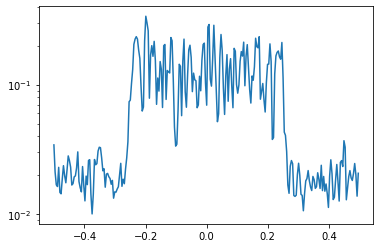


Angle -- NN Output:  -0.11786606046371162 Actual Label:  -1.8545659321990857
Start -- CNN Output:  1082.865966796875 Actual Label:  1079.0
Stop -- CNN Output:  1807.842529296875 Actual Label:  1809.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


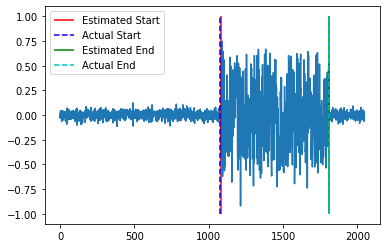

Center Frequency -- CNN Output:  -0.002687914 Actual Label:  -0.0110772
Bandwidth -- CNN Output:  0.52674663 Actual Label:  0.5311268


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


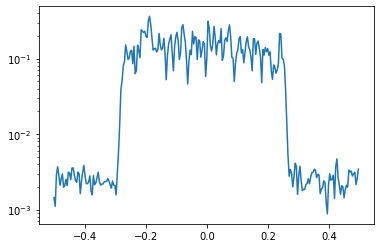


Angle -- NN Output:  -24.902953505516052 Actual Label:  -21.017297613633893
Start -- CNN Output:  430.81573486328125 Actual Label:  439.0
Stop -- CNN Output:  1326.380126953125 Actual Label:  1342.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


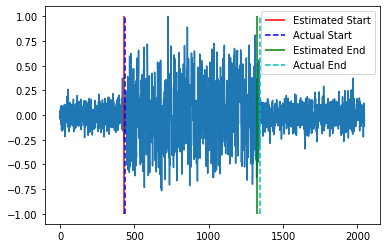

Center Frequency -- CNN Output:  -0.07355499 Actual Label:  -0.0743612
Bandwidth -- CNN Output:  0.48724416 Actual Label:  0.4677432


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


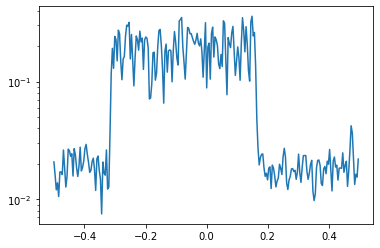


Angle -- NN Output:  48.10412049293518 Actual Label:  56.28282915072021
Start -- CNN Output:  268.9888000488281 Actual Label:  265.0
Stop -- CNN Output:  1030.8968505859375 Actual Label:  1041.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


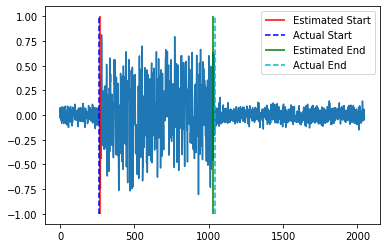

Center Frequency -- CNN Output:  -0.02236927 Actual Label:  -0.026689
Bandwidth -- CNN Output:  0.4488346 Actual Label:  0.4512472


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


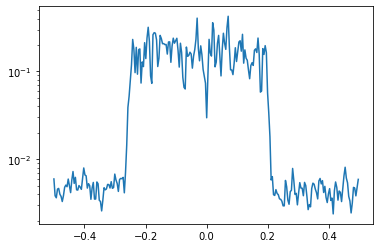


Angle -- NN Output:  44.39372956752777 Actual Label:  33.34975053229739
Start -- CNN Output:  135.3176727294922 Actual Label:  129.0
Stop -- CNN Output:  1575.208740234375 Actual Label:  1583.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


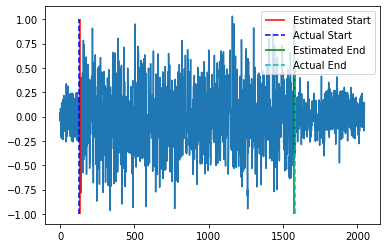

Center Frequency -- CNN Output:  0.09065153 Actual Label:  0.0810924
Bandwidth -- CNN Output:  0.556054 Actual Label:  0.5483142


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


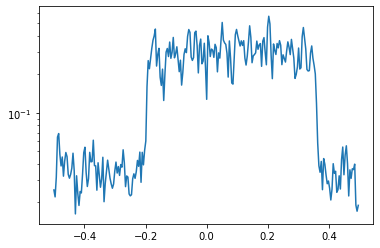


Angle -- NN Output:  13.887342363595963 Actual Label:  11.824059708694579
Start -- CNN Output:  95.80157470703125 Actual Label:  110.0
Stop -- CNN Output:  2005.029541015625 Actual Label:  2047.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


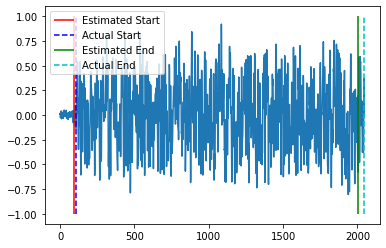

Center Frequency -- CNN Output:  0.067786835 Actual Label:  0.0653842
Bandwidth -- CNN Output:  0.24291918 Actual Label:  0.2620356


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


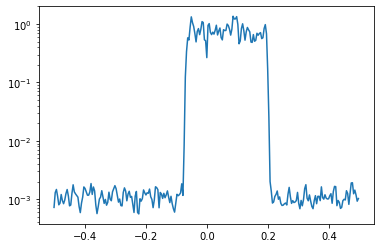


Angle -- NN Output:  -45.16208589076996 Actual Label:  -36.194304430158454
Start -- CNN Output:  73.8021469116211 Actual Label:  53.0
Stop -- CNN Output:  1596.4259033203125 Actual Label:  1594.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


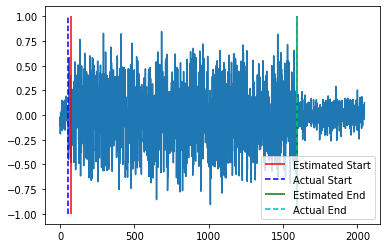

Center Frequency -- CNN Output:  -0.0040865955 Actual Label:  -0.001667
Bandwidth -- CNN Output:  0.7408898 Actual Label:  0.7392284


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


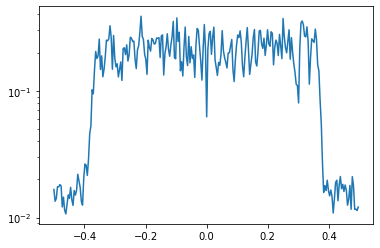


Angle -- NN Output:  -13.450948297977448 Actual Label:  -13.52565497624974
Start -- CNN Output:  1538.90869140625 Actual Label:  1530.0
Stop -- CNN Output:  2029.0582275390625 Actual Label:  2031.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


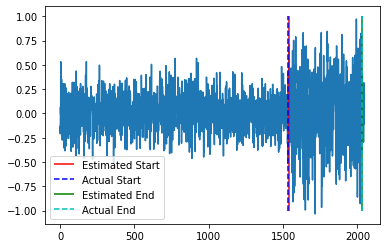

Center Frequency -- CNN Output:  0.018356208 Actual Label:  0.026177
Bandwidth -- CNN Output:  0.54310894 Actual Label:  0.5572602


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


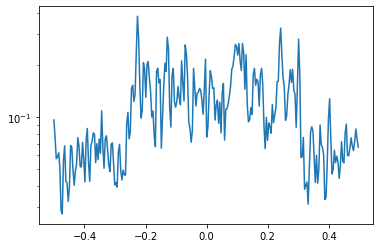


Angle -- NN Output:  -4.158727861940861 Actual Label:  -1.2184744004209325
Start -- CNN Output:  297.5422058105469 Actual Label:  314.0
Stop -- CNN Output:  1724.934326171875 Actual Label:  1743.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


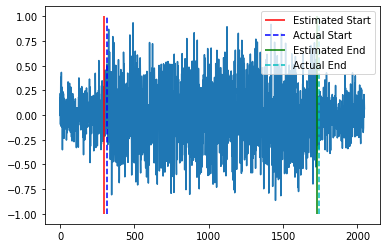

Center Frequency -- CNN Output:  0.020335741 Actual Label:  0.017809
Bandwidth -- CNN Output:  0.79716986 Actual Label:  0.802187


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


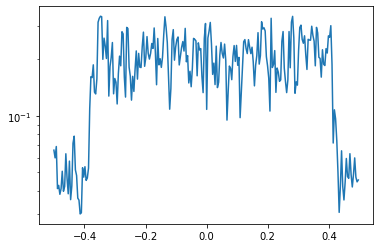


Angle -- NN Output:  -36.65635049343109 Actual Label:  -48.02015828043311
Start -- CNN Output:  543.5623168945312 Actual Label:  529.0
Stop -- CNN Output:  1074.76123046875 Actual Label:  1077.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


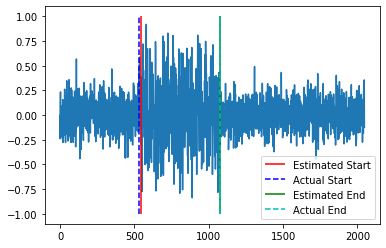

Center Frequency -- CNN Output:  -0.0012604111 Actual Label:  -0.0008048
Bandwidth -- CNN Output:  0.48399684 Actual Label:  0.4708724


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


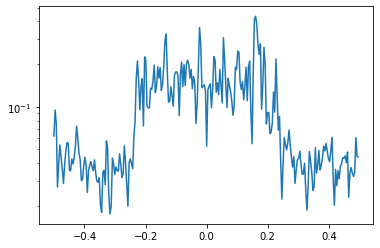


Angle -- NN Output:  -1.396996295079589 Actual Label:  -4.789016417224046
Start -- CNN Output:  190.92710876464844 Actual Label:  208.0
Stop -- CNN Output:  1809.5191650390625 Actual Label:  1820.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


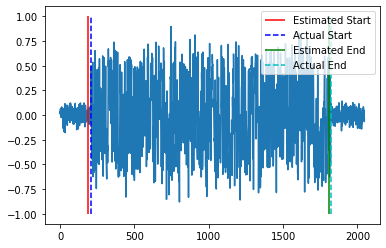

Center Frequency -- CNN Output:  0.110955305 Actual Label:  0.100839
Bandwidth -- CNN Output:  0.3143387 Actual Label:  0.2991862


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


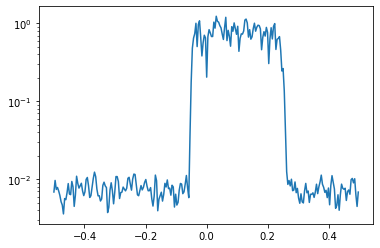


Angle -- NN Output:  43.55350881814957 Actual Label:  35.67376164897363
Start -- CNN Output:  855.5552978515625 Actual Label:  851.0
Stop -- CNN Output:  1562.4466552734375 Actual Label:  1540.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


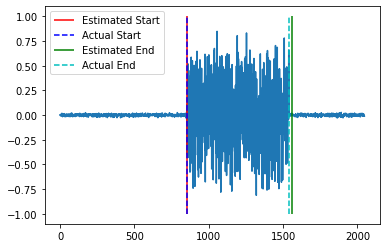

Center Frequency -- CNN Output:  0.0029255615 Actual Label:  -0.0005722
Bandwidth -- CNN Output:  0.8183241 Actual Label:  0.8192058


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


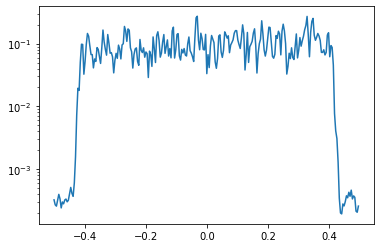


Angle -- NN Output:  -39.48741674423218 Actual Label:  -45.09268311090604
Start -- CNN Output:  138.9043426513672 Actual Label:  157.0
Stop -- CNN Output:  1769.2852783203125 Actual Label:  1790.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


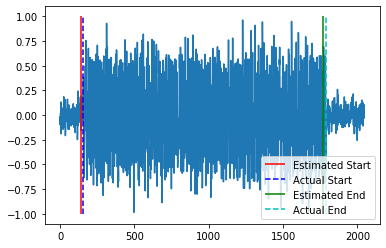

Center Frequency -- CNN Output:  0.13687076 Actual Label:  0.1360674
Bandwidth -- CNN Output:  0.2284568 Actual Label:  0.2186626


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


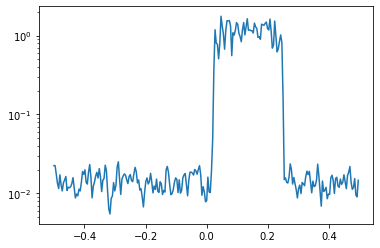


Angle -- NN Output:  -50.57118952274323 Actual Label:  -43.89976461356006
Start -- CNN Output:  1335.9295654296875 Actual Label:  1337.0
Stop -- CNN Output:  1917.66357421875 Actual Label:  1922.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


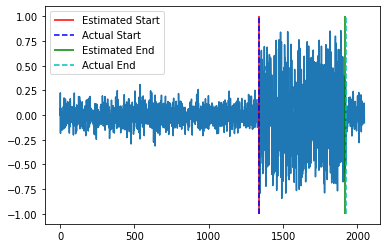

Center Frequency -- CNN Output:  -0.025955962 Actual Label:  -0.0255204
Bandwidth -- CNN Output:  0.83457917 Actual Label:  0.8049296


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


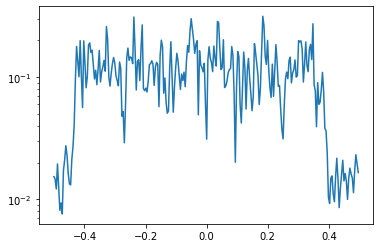


Angle -- NN Output:  -37.8996616601944 Actual Label:  -31.04139296713295
Start -- CNN Output:  338.3153076171875 Actual Label:  349.0
Stop -- CNN Output:  1083.3477783203125 Actual Label:  1095.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


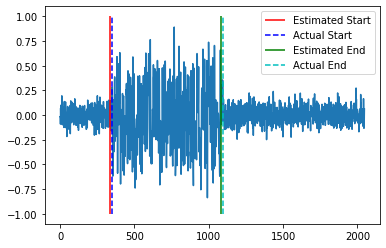

Center Frequency -- CNN Output:  -0.005997411 Actual Label:  -0.0055282
Bandwidth -- CNN Output:  0.3785489 Actual Label:  0.3867522


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


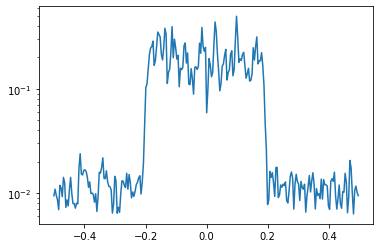


Angle -- NN Output:  -44.65502232313156 Actual Label:  -39.63808226253197
Start -- CNN Output:  130.79673767089844 Actual Label:  116.0
Stop -- CNN Output:  973.3063354492188 Actual Label:  978.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


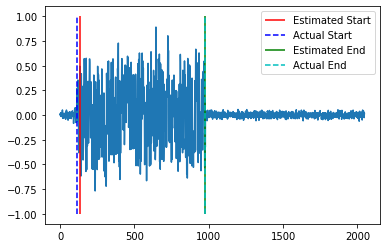

Center Frequency -- CNN Output:  0.10653752 Actual Label:  0.1141478
Bandwidth -- CNN Output:  0.34500518 Actual Label:  0.3302512


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


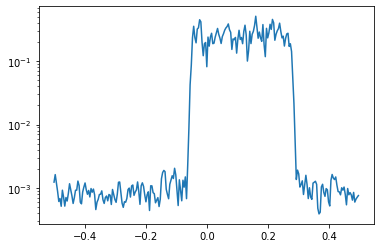


Angle -- NN Output:  7.253569588065147 Actual Label:  8.079014948450673
Start -- CNN Output:  116.48927307128906 Actual Label:  125.0
Stop -- CNN Output:  667.468505859375 Actual Label:  664.0


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


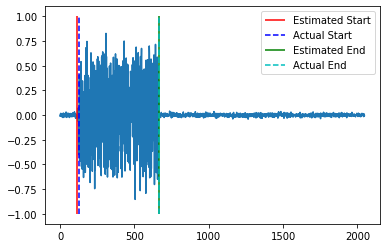

Center Frequency -- CNN Output:  0.01313322 Actual Label:  0.013707
Bandwidth -- CNN Output:  0.7282634 Actual Label:  0.7205832


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


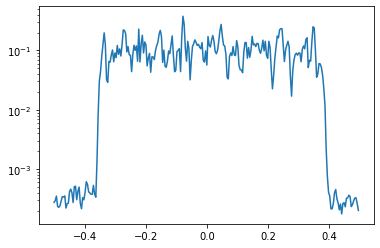

In [18]:
#This is just code to test the neural network to see how it is performing

results = model.predict([test_angleX, test_timeX, test_freqX])


for q in range(20):
    i = np.random.randint(0,len(test_timeX)) # Print the results for a random signal
    
    # Print the AoA, Start, Stop CNN predictions as well as the actual labels
    print("Angle -- NN Output: ", results[0][i,0]*180/np.pi*np.pi/2, "Actual Label: ", test_angleY[i]*180/np.pi*np.pi/2)
    print("Start -- CNN Output: ", results[1][i,0]*len(signal_0[0]), "Actual Label: ", test_timeY[i,0]*len(signal_0[0]))
    print("Stop -- CNN Output: ", results[1][i,1]*len(signal_0[0]), "Actual Label: ", test_timeY[i,1]*len(signal_0[0]))
    
    # Plot the time version of the signal as well as lines showing Estimated start/stop vs Actual start/stop
    plt.plot(range(len(test_timeX[i])), test_timeX[i])
    plt.vlines(x=round(results[1][i,0]*len(signal_0[0])), ymin = -1, ymax = 1, colors = 'r', linestyles = 'solid', label = 'Estimated Start')
    plt.vlines(x=round(test_timeY[i,0]*len(signal_0[0])), ymin = -1, ymax = 1, colors = 'b', linestyles = 'dashed', label = 'Actual Start')
    plt.vlines(x=round(results[1][i,1]*len(signal_0[0])), ymin = -1, ymax = 1, colors = 'g', linestyles = 'solid', label = 'Estimated End')
    plt.vlines(x=round(test_timeY[i,1]*len(signal_0[0])), ymin = -1, ymax = 1, colors = 'c', linestyles = 'dashed', label = 'Actual End')
    plt.legend()
    plt.show()
    
    # Print the frequency outputs of the NN
    print("Center Frequency -- CNN Output: ", results[2][i,0], "Actual Label: ", test_freqY[i,0])
    print("Bandwidth -- CNN Output: ", results[2][i,1], "Actual Label: ", test_freqY[i,1])
    
    # Plot the FFT of the signal
    f, P = signal.welch(test_timeX[i])
    f = np.fft.fftshift(f)
    P = np.fft.fftshift(P)
    
    # Plot vertical lines showing estimated bandwidth of the signal vs actual bandwidth and estimated center freq vs actual center freq
    start =(results[2][i,0] - results[2][i,1]/2) # Calculates where the estimated "Start" of the signal is based off the bandwidth and cf prediction
    end =  (results[2][i,0] + results[2][i,1]/2) # Calculates where the estimated "End" of the signal is based off the bandwidth and cf prediction
    act_start = (test_freqY[i,0] - test_timeY[i,1]/2)  # Calculates where the actual "Start" of the signal is based off the bandwidth and cf labels
    act_end = (test_freqY[i,0] + test_timeY[i,1]/2) # Calculates where the actual "End" of the signal is based off the bandwidth and cf labels
    
    center = results[2][i,0] # Predicted cf
    act_center = test_freqY[i,0] # Actual cf
    
    plt.semilogy(f,P)
    #plt.vlines(x=start, ymin = -.1, ymax = 1, colors = 'r', linestyles = 'solid', label = 'Estimated Start')
    #plt.vlines(x=act_start, ymin = -.1, ymax = 1, colors = 'b', linestyles = 'dashed', label = 'Actual Start')
    #plt.vlines(x=end, ymin = -.1, ymax = 1, colors = 'g', linestyles = 'solid', label = 'Estimated End')
    #plt.vlines(x=act_end, ymin = -.1, ymax = 1, colors = 'c', linestyles = 'dashed', label = 'Actual End')
    #plt.vlines(x=center, ymin = -.1, ymax = 1, colors = 'k', linestyles = 'dashed', label = 'Estimated Center')
    #plt.vlines(x=act_center, ymin = -.1, ymax = 1, colors = 'm', linestyles = 'dashed', label = 'Actual Center')
    #plt.legend()
    plt.show()
    print()

In [19]:
# Save the model as an .h5 file
model.save("All_In_One_NN_2048.h5")